In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import itertools
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

0


In [5]:
#Beats generation,
#we defined a single ECG beat image by centering the Q-wave peak signal while
#excluding the first and the last 20 ECG signals from the previous and afterward Q-wave peak signal
#https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb
#https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm
#http://www.tara.tcd.ie/bitstream/handle/2262/17623/automatic.pdf?sequence=1
def labeltotext(val):
    if val in ['N','L','R','e','j'] :
        return 0 #N
    elif val in ['A','a','J','S']:
        return 1 #S
    elif val in ['V','E']:
        return 2 #V
    elif val == 'F':
        return 3 #F
    elif val in ['/','f','Q']:
        return 4 #Q
    else: 
        pass
    
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
right_len = 180 #right sample length around of peak value of QRS
left_len = 20 #left sample length around of peak value of QRS
#get trainset
trData = [] #[QRS value, label]
for bt in [101,106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230]:#22 records for train
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    #for j, val in enumerate(lead_name):
                        #QRS_value = signal[:,j][min_idx:max_idx]
                        #data.append([QRS_value,labeltotext(qrs_sym[i]),val])#[QRS value, label, lead name]
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    trData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass
    
trData = pd.DataFrame(np.array(trData))
X_train = pd.DataFrame(trData[0].values.tolist())
y_train = trData[1]
print('The shape of trainset is: (%d,%d)'%(X_train.shape[0],X_train.shape[1]))
print(trData[1].value_counts())
#get testset
teData = [] #[QRS value, label]
for bt in [100,103,105,111,113,117,121,123,200,202,210,212,213,214,219,221,222,228,231,232,233,234]:#22 records for test
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    #for j, val in enumerate(lead_name):
                        #QRS_value = signal[:,j][min_idx:max_idx]
                        #data.append([QRS_value,labeltotext(qrs_sym[i]),val])#[QRS value, label, lead name]
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    teData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass

teData = pd.DataFrame(np.array(teData))
X_test = pd.DataFrame(teData[0].values.tolist())
y_test = teData[1]
print('The shape of testset is: (%d,%d)'%(X_test.shape[0],X_test.shape[1]))
print(teData[1].value_counts())

The shape of trainset is: (51009,200)
0    45854
2     3788
1      944
3      415
4        8
Name: 1, dtype: int64
The shape of testset is: (49698,200)
0    44245
2     3221
1     1837
3      388
4        7
Name: 1, dtype: int64


In [79]:
#model: faiss+index
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(right_len+left_len) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(X_train, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
X_test = np.ascontiguousarray(X_test, dtype=np.float32)
scores, neighbors = gpu_index.search(X_test, k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(y_train)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(y_test.tolist(), y_pred))
#confusion matrix
labels = list(set(y_pred))
cm = confusion_matrix(y_test.tolist(), y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

Completed buliding index in 1 seconds
Accuracy: 0.826814
[[38424  2401  2534   854    32]
 [ 1758    42     8    29     0]
 [  495    79  2624    23     0]
 [  260     0   127     1     0]
 [    2     0     5     0     0]]
Specificity: 0.868437
Sensitivity of S: 0.022863
Sensitivity of V: 0.814654
Sensitivity of F: 0.002577
Sensitivity of Q: 0.000000


In [80]:
#model: LSH
from sklearn.neighbors import LSHForest
lshf = LSHForest(min_hash_match=4, n_neighbors=20, n_candidates=10, n_estimators =10, random_state=42) #hashcode=32
lshf.fit(X_train)  
distances, indices = lshf.kneighbors(X_test, n_neighbors=1)#top1
y_pred = []
for i in indices.flatten():
    y_pred.append(np.array(y_train)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(y_test.tolist(), y_pred))
#confusion matrix
labels = list(set(y_pred))
cm = confusion_matrix(y_test.tolist(), y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

/root/miniconda3/lib/python3.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


Accuracy: 0.819872
[[38020  1574  3375  1265    11]
 [ 1425    56   311    45     0]
 [  487    50  2664    20     0]
 [  345     1    37     5     0]
 [    4     0     2     0     1]]
Specificity: 0.859306
Sensitivity of S: 0.030484
Sensitivity of V: 0.827072
Sensitivity of F: 0.012887
Sensitivity of Q: 0.142857


In [18]:
#AHA2MIT
#https://archive.physionet.org/physiobank/annotations.shtml
def labeltotext(val):
    if val in ['N','L','R','e','j'] :
        return 0 #N
    elif val in ['A','a','J','S']:
        return 1 #S
    elif val in ['V','E']:
        return 2 #V
    elif val == 'F':
        return 3 #F
    elif val in ['/','f','Q']:
        return 4 #Q
    else: 
        pass
rootdir = '/data/fjsdata/ECG/AHA2MIT'
filename = list(set( [os.path.splitext(base)[0] for base in os.listdir(rootdir)]) )
teData = [] #[QRS value, label]
right_len = 180 #right sample length around of peak value of QRS
left_len = 20 #left sample length around of peak value of QRS
for bt in filename:#22 records for test
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        #print (list(set(qrs_sym)))
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']:#five diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    teData.append([QRS_value, labeltotext(qrs_sym[i])])
    except:
        pass

teData = pd.DataFrame(np.array(teData))
X_test = pd.DataFrame(teData[0].values.tolist()).fillna(0)
y_test = teData[1]
print('The shape of testset is: (%d,%d)'%(X_test.shape[0],X_test.shape[1]))
print(teData[1].value_counts())

The shape of testset is: (352685,200)
0    316492
2     31184
4      3743
3      1266
Name: 1, dtype: int64


In [19]:
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(right_len+left_len) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(X_train, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
X_test = np.ascontiguousarray(X_test, dtype=np.float32)
scores, neighbors = gpu_index.search(X_test, k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(y_train)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(y_test.tolist(), y_pred))
#confusion matrix
labels = list(set(y_pred))
cm = confusion_matrix(y_test.tolist(), y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

Completed buliding index in 1 seconds
Accuracy: 0.728449
[[239360  28611  33447  14790    284]
 [     0      0      0      0      0]
 [ 10885   2187  17484    612     16]
 [   538    363    299     64      2]
 [   686    292   2742     18      5]]
Specificity: 0.756291
Sensitivity of S: nan
Sensitivity of V: 0.560672
Sensitivity of F: 0.050553
Sensitivity of Q: 0.001336


/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [20]:
#model: LSH
from sklearn.neighbors import LSHForest
lshf = LSHForest(min_hash_match=4, n_neighbors=20, n_candidates=10, n_estimators =10, random_state=42) #hashcode=32
lshf.fit(X_train)  
distances, indices = lshf.kneighbors(X_test, n_neighbors=1)#top1
y_pred = []
for i in indices.flatten():
    y_pred.append(np.array(y_train)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(y_test.tolist(), y_pred))
#confusion matrix
labels = list(set(y_pred))
cm = confusion_matrix(y_test.tolist(), y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

/root/miniconda3/lib/python3.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


Accuracy: 0.595560
[[190043   8886  64115  53174    274]
 [     0      0      0      0      0]
 [  8504   1807  19866    989     18]
 [   432     85    619    130      0]
 [   560    714   2448     15      6]]
Specificity: 0.600467
Sensitivity of S: nan
Sensitivity of V: 0.637057
Sensitivity of F: 0.102686
Sensitivity of Q: 0.001603


/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


Normalized confusion matrix
[[9.92497580e-01 4.84027106e-04 1.21006776e-03 5.80832527e-03
  0.00000000e+00]
 [1.24843945e-02 9.81273408e-01 1.49812734e-03 3.49563046e-03
  1.24843945e-03]
 [7.23372412e-03 7.48316288e-04 9.91020205e-01 9.97755051e-04
  0.00000000e+00]
 [1.11111111e-02 1.72839506e-03 2.46913580e-04 9.57530864e-01
  2.93827160e-02]
 [7.74225774e-03 2.49750250e-04 1.99800200e-03 6.99300699e-03
  9.83016983e-01]]


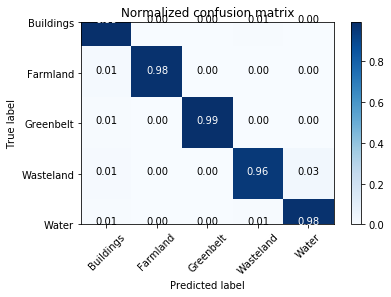

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    # plt.savefig('confusion_matrix',dpi=200)
    
cnf_matrix = np.array([
    [4101, 2, 5, 24, 0],
    [50, 3930, 6, 14, 5],
    [29, 3, 3973, 4, 0],
    [45, 7, 1, 3878, 119],
    [31, 1, 8, 28, 3936],
])
# Plot normalized confusion matrix 
class_names = ['Buildings', 'Farmland', 'Greenbelt', 'Wasteland', 'Water']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')